This notebook is to verify that the rotary positionall embeddings are correct

In [1]:
!pip install rotary-embedding-torch

  Obtaining dependency information for rotary-embedding-torch from https://files.pythonhosted.org/packages/ea/3f/1f826b27e756bcc99921e78b49d92ae3335d4ca3d6b8034571fe4dac1510/rotary_embedding_torch-0.2.7-py3-none-any.whl.metadata


In [1]:
import torch
from rotary_embedding_torch import RotaryEmbedding
import matplotlib.pyplot as plt
import numpy as np

In [165]:
# Dimensions
seq_len = 16
dim = 256

# Dummy query and key matrices
# q = torch.randn(seq_len, dim)
q = torch.stack([torch.arange(0, dim) for _ in range(seq_len)]).float()
k = torch.randn(seq_len, dim)

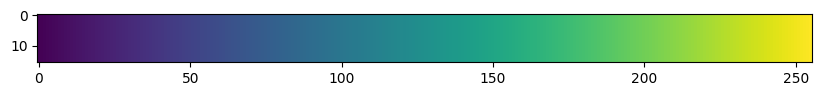

In [166]:
plt.figure(figsize=(10, 10))
plt.imshow(q);

In [167]:
rotary_emb = RotaryEmbedding(dim = dim)
roated_q = rotary_emb.rotate_queries_or_keys(q)

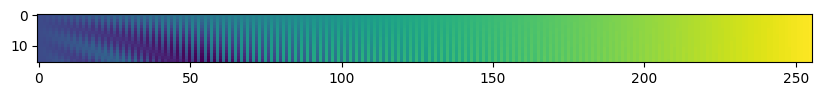

In [168]:
plt.figure(figsize=(10, 10))
plt.imshow(roated_q);

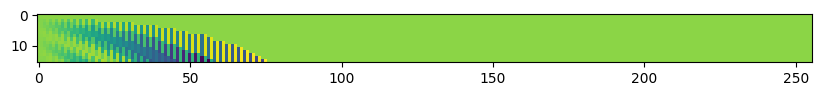

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(roated_q-q);

In [12]:
from einops import rearrange, repeat

def rotate_half(x):
    x = rearrange(x, '... (d r) -> ... d r', r = 2)
    x1, x2 = x.unbind(dim = -1)
    x = torch.stack((-x2, x1), dim = -1)
    print(x1.shape)
    return rearrange(x, '... d r -> ... (d r)')

def apply_rotary_emb(freqs, t, start_index = 0, scale = 1.):
    freqs = freqs.to(t)
    rot_dim = freqs.shape[-1]
    end_index = start_index + rot_dim
    assert rot_dim <= t.shape[-1], f'feature dimension {t.shape[-1]} is not of sufficient size to rotate in all the positions {rot_dim}'
    t_left, t, t_right = t[..., :start_index], t[..., start_index:end_index], t[..., end_index:]
    t = (t * freqs.cos() * scale) + (rotate_half(t) * freqs.sin() * scale)
    return torch.cat((t_left, t, t_right), dim = -1)

def forward(t, seq_len):
    seq_pos = torch.arange(0, seq_len)
    freqs = torch.einsum('..., f -> ... f', t.type(freqs.dtype), freqs)
    freqs = repeat(freqs, '... n -> ... (n r)', r = 2)


torch.Size([16, 64])


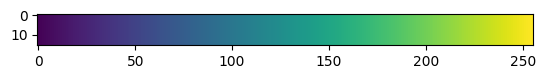

In [13]:
plt.imshow(apply_rotary_emb(rotary_emb.freqs, q));

In [163]:
f = rotary_emb.cache['freqs:16|offset:0']
f

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 1.0000e+00, 9.3057e-01,  ..., 1.1548e-04, 1.0746e-04,
         1.0746e-04],
        [2.0000e+00, 2.0000e+00, 1.8611e+00,  ..., 2.3096e-04, 2.1492e-04,
         2.1492e-04],
        ...,
        [1.3000e+01, 1.3000e+01, 1.2097e+01,  ..., 1.5012e-03, 1.3970e-03,
         1.3970e-03],
        [1.4000e+01, 1.4000e+01, 1.3028e+01,  ..., 1.6167e-03, 1.5045e-03,
         1.5045e-03],
        [1.5000e+01, 1.5000e+01, 1.3959e+01,  ..., 1.7322e-03, 1.6119e-03,
         1.6119e-03]])

In [50]:
rot_dim = f.to(q).shape[-1]
rot_dim

256

In [51]:
start_index = 0
end_index = rotary_emb.freqs.to(q).shape[-1] + start_index
end_index

128

In [52]:
t_left, t, t_right = q[..., :start_index], q[..., start_index:end_index], q[..., end_index:]

In [53]:
t = (t * f.cos() * 1) + (rotate_half(t) * f.sin() * 1)

RuntimeError: The size of tensor a (128) must match the size of tensor b (256) at non-singleton dimension 1

In [54]:
torch.cat((t_left, t, t_right), dim = -1).shape

torch.Size([16, 256])

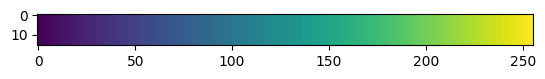

In [55]:
plt.imshow(torch.cat((t_left, t, t_right), dim = -1));

In [39]:
rotary_emb.cache['freqs:16|offset:0']

tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [ 1,  1,  0,  ...,  0,  0,  0],
        [ 2,  2,  1,  ...,  0,  0,  0],
        ...,
        [13, 13, 12,  ...,  0,  0,  0],
        [14, 14, 13,  ...,  0,  0,  0],
        [15, 15, 13,  ...,  0,  0,  0]])

torch.Size([16, 128])


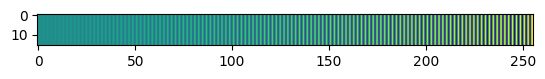

In [22]:
plt.imshow(rotate_half(q));

In [23]:
x = rearrange(q, '... (d r) -> ... d r', r = 2)
x1, x2 = x.unbind(dim = -1)
x = torch.stack((-x2, x1), dim = -1)
print(x.shape)
x = rearrange(x, '... d r -> ... (d r)')

torch.Size([16, 128, 2])


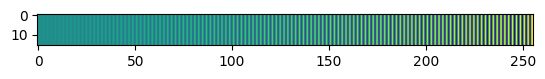

In [24]:
plt.imshow(x);

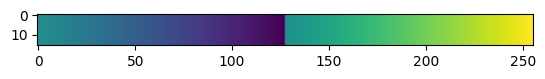

In [25]:
def rotate_half(x):
    """Rotate the tensor's last dimension by half its size."""
    return torch.cat((-x[..., 1::2], x[..., ::2]), dim=-1)
plt.imshow(rotate_half(q));

In [132]:
def rotate_half(x):
    x = torch.stack((-x[..., 1::2], x[..., ::2]), dim=-1)
    
    if len(x.shape) == 4:
        x = x.view(x.size(0), x.size(1), -1)
    elif len(x.shape) == 3:
        x = x.view(x.size(0), -1)
    else:
        raise RuntimeError(f"Positional embeddings cannot handle shape of {len(x.shape)}")
    
    return x

def sinusoidal_embeddings(max_seq_length:int, model_dim:int):
    positions = torch.arange(0, max_seq_length).float().unsqueeze(1)

    div_func = lambda i: np.power(10000, (i / model_dim))
    divisor = torch.arange(0, model_dim, 2).float().apply_(div_func)

    sin = torch.sin(positions / divisor)
    cos = torch.cos(positions / divisor)

    sin = torch.stack([sin, sin], dim=-1).view(max_seq_length, model_dim)
    cos = torch.stack([cos, cos], dim=-1).view(max_seq_length, model_dim)

    # sin = torch.cat([sin, sin], dim=-1)
    # cos = torch.cat([cos, cos], dim=-1)

    return (sin, cos)

def ROPE(x):        
    assert len(x.shape) == 2, "'x' needs to be of shape (sequence_length, model_dimension)"
    
    sin, cos = sinusoidal_embeddings(q.shape[0], q.shape[1])
        
    x2 = rotate_half(x)
    return (x * cos[:x.shape[0], :]) + (x2 * sin[:x.shape[0], :])


ROPE(q)

tensor([[ 0.0000e+00,  1.0000e+00,  2.0000e+00,  ...,  2.5300e+02,
          2.5400e+02,  2.5500e+02],
        [-8.4147e-01,  5.4030e-01, -1.2111e+00,  ...,  2.5303e+02,
          2.5397e+02,  2.5503e+02],
        [-9.0930e-01, -4.1615e-01, -3.4470e+00,  ...,  2.5306e+02,
          2.5395e+02,  2.5505e+02],
        ...,
        [-4.2017e-01,  9.0745e-01,  3.1399e+00,  ...,  2.5338e+02,
          2.5364e+02,  2.5535e+02],
        [-9.9061e-01,  1.3674e-01,  4.5440e-01,  ...,  2.5341e+02,
          2.5362e+02,  2.5538e+02],
        [-6.5029e-01, -7.5969e-01, -2.5970e+00,  ...,  2.5344e+02,
          2.5359e+02,  2.5541e+02]])

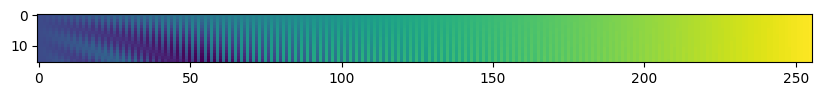

In [159]:
plt.figure(figsize=(10, 10))
plt.imshow(ROPE(q));

In [140]:
theta = 10000.0
dim = 256
freqs = 1. / (theta ** (torch.arange(0, dim, 2)[:(dim // 2)].float() / dim))
freqs

tensor([1.0000e+00, 9.3057e-01, 8.6596e-01, 8.0584e-01, 7.4989e-01, 6.9783e-01,
        6.4938e-01, 6.0430e-01, 5.6234e-01, 5.2330e-01, 4.8697e-01, 4.5316e-01,
        4.2170e-01, 3.9242e-01, 3.6517e-01, 3.3982e-01, 3.1623e-01, 2.9427e-01,
        2.7384e-01, 2.5483e-01, 2.3714e-01, 2.2067e-01, 2.0535e-01, 1.9110e-01,
        1.7783e-01, 1.6548e-01, 1.5399e-01, 1.4330e-01, 1.3335e-01, 1.2409e-01,
        1.1548e-01, 1.0746e-01, 1.0000e-01, 9.3057e-02, 8.6596e-02, 8.0584e-02,
        7.4989e-02, 6.9783e-02, 6.4938e-02, 6.0430e-02, 5.6234e-02, 5.2330e-02,
        4.8697e-02, 4.5316e-02, 4.2170e-02, 3.9242e-02, 3.6517e-02, 3.3982e-02,
        3.1623e-02, 2.9427e-02, 2.7384e-02, 2.5483e-02, 2.3714e-02, 2.2067e-02,
        2.0535e-02, 1.9110e-02, 1.7783e-02, 1.6548e-02, 1.5399e-02, 1.4330e-02,
        1.3335e-02, 1.2409e-02, 1.1548e-02, 1.0746e-02, 1.0000e-02, 9.3057e-03,
        8.6596e-03, 8.0584e-03, 7.4989e-03, 6.9783e-03, 6.4938e-03, 6.0430e-03,
        5.6234e-03, 5.2330e-03, 4.8697e-

In [141]:
t = torch.arange(16)
freqs = torch.einsum('..., f -> ... f', t.type(freqs.dtype), freqs)
freqs = repeat(freqs, '... n -> ... (n r)', r = 2)
freqs.shape

torch.Size([16, 256])

In [142]:
freqs.to(q)

tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [ 1,  1,  0,  ...,  0,  0,  0],
        [ 2,  2,  1,  ...,  0,  0,  0],
        ...,
        [13, 13, 12,  ...,  0,  0,  0],
        [14, 14, 13,  ...,  0,  0,  0],
        [15, 15, 13,  ...,  0,  0,  0]])

In [143]:
from einops import rearrange, repeat

def rotate_half_o(x):
    x = rearrange(x, '... (d r) -> ... d r', r = 2)
    x1, x2 = x.unbind(dim = -1)
    x = torch.stack((-x2, x1), dim = -1)
    return rearrange(x, '... d r -> ... (d r)')

t = q
rot_dim = freqs.shape[-1]
scale = 1
t1 = (t * freqs.cos() * scale) + (rotate_half_o(t) * freqs.sin() * scale)
t1

tensor([[ 0.0000e+00,  1.0000e+00,  2.0000e+00,  ...,  2.5300e+02,
          2.5400e+02,  2.5500e+02],
        [-8.4147e-01,  5.4030e-01, -1.2111e+00,  ...,  2.5303e+02,
          2.5397e+02,  2.5503e+02],
        [-9.0930e-01, -4.1615e-01, -3.4470e+00,  ...,  2.5306e+02,
          2.5395e+02,  2.5505e+02],
        ...,
        [-4.2017e-01,  9.0745e-01,  3.1399e+00,  ...,  2.5338e+02,
          2.5364e+02,  2.5535e+02],
        [-9.9061e-01,  1.3674e-01,  4.5440e-01,  ...,  2.5341e+02,
          2.5362e+02,  2.5538e+02],
        [-6.5029e-01, -7.5969e-01, -2.5970e+00,  ...,  2.5344e+02,
          2.5359e+02,  2.5541e+02]])

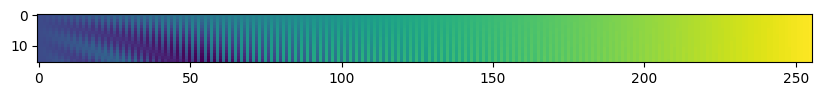

In [149]:
plt.figure(figsize=(10, 10))
plt.imshow(t1);

In [145]:
max_seq_length, model_dim = q.shape
positions = torch.arange(0, max_seq_length).float().unsqueeze(1)

div_func = lambda i: np.power(10000, (i / model_dim))
divisor = torch.arange(0, model_dim, 2).float().apply_(div_func)
# sin = torch.sin(positions / divisor)
# sin
f = positions/divisor
f = torch.stack([f, f], dim=-1).view(max_seq_length, model_dim)


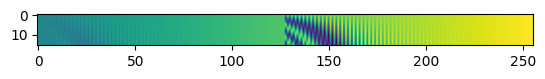

In [27]:
plt.imshow(ROPE(q));

In [28]:
q.shape

torch.Size([16, 256])

In [32]:
(rotate_half(q) == x).all()

tensor(True)

In [ ]:
(torch.stack((-q[..., 1::2], q[..., ::2]), dim=-1) == torch.stack((-x2, x1), dim = -1)).all()

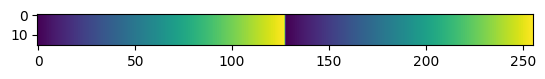

In [30]:
plt.imshow(torch.cat((q[..., 1::2], q[..., ::2]), dim=-1));